In [0]:
import os
os.chdir('/content/drive/My Drive/BUSI')

# Import modules

In [0]:
import math
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, Dense, Flatten, Activation,
    InputLayer, BatchNormalization, 
    Concatenate, MaxPooling2D, Layer, 
    UpSampling2D, Conv2DTranspose, Input
) 
from tensorflow.keras.models import Model

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint,
    ReduceLROnPlateau
)
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, Iterator
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# STAN Model implementation

### Blocks

In [0]:
class Conv2DBlock(Layer):
    def __init__(
        self,
        n_filters,
        kernel_size,
        activation='relu',
        use_bn=False,
        name='conv2d',
        **kwargs
    ):
        super(Conv2DBlock, self).__init__()
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.use_bn = use_bn
        self.conv = Conv2D(n_filters, kernel_size, name=f'{name}_conv',
                            use_bias=(not use_bn), padding='same', **kwargs)
        self.use_bn = use_bn
        if use_bn:
            # self.bn = BatchNorm(name=f'{name}_bn')
            self.bn = BatchNormalization(name=f'{name}_bn')
        self.activation = Activation(activation, name=f'{name}_activation')
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        x = self.activation(x)
        return x

    def get_config(self):
        config = super(Conv2DBlock, self).get_config()
        config.update({
            'n_filters': self.n_filters,
            'kernel_size': self.kernel_size,
            'activation': self.activation,
            'use_bn': self.use_bn
        })
        return config


class BatchNorm(BatchNormalization):
    """
    Make trainable=False freeze BN for real (the og version is sad)
    """
    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)


class EncoderBlock(Layer):
    def __init__(self, n_filters, name='enc'):
        super(EncoderBlock, self).__init__()
        self.n_filters = n_filters
        self.conv3_1 = Conv2DBlock(n_filters=n_filters, kernel_size=3, name=f'{name}_kernel3_1')
        self.conv3_2 = Conv2DBlock(n_filters=n_filters, kernel_size=3, name=f'{name}_kernel3_2')
        self.conv3_pool = MaxPooling2D(pool_size=(2,2), name=f'{name}_kernel3_pool')

        self.conv1_1 = Conv2DBlock(n_filters=n_filters, kernel_size=1, name=f'{name}_kernel1_1')
        self.conv1_2 = Conv2DBlock(n_filters=n_filters, kernel_size=1, name=f'{name}_kernel1_2')

        self.conv5_1 = Conv2DBlock(n_filters=n_filters, kernel_size=5, name=f'{name}_kernel5_1')
        self.conv5_2 = Conv2DBlock(n_filters=n_filters, kernel_size=5, name=f'{name}_kernel5_1')
        self.agg_pool = MaxPooling2D(pool_size=(2,2), name=f'{name}_agg_pool')


    def call(self, kernel3_inp, kernelconcat_inp):
        """Feed forward through the Encoder block

        Arguments:
            kernel3_inp {tensor} -- feature maps of kernel3 conv from previous block or just an image
            kernelconcat_inp {[type]} -- feature maps of concatenation (kernel1 + kernel5) from previous block or just an image

        Returns:
            tuple -- (kernel3 output, concat output, skip connection 1, skip connection 2)
        """

        x1 = self.conv1_1(kernelconcat_inp)
        x1 = self.conv1_2(x1)

        x5 = self.conv5_1(kernelconcat_inp)
        x5 = self.conv5_2(x5)
        
        concat = tf.concat([x1, x5], axis=3)
        concat_pool = self.agg_pool(concat)

        x3 = x3_1 = self.conv3_1(kernel3_inp)
        x3 = skip1 = self.conv3_2(x3)
        x3_pool = self.conv3_pool(x3)

        skip2 = tf.concat([x3_1, concat], axis=3)
        return x3_pool, concat_pool, skip1, skip2

    def get_config(self):
        """ Gets the configuration of this layer.

        Returns
            Dictionary containing the parameters of this layer.
        """        
        config = super(EncoderBlock, self).get_config()
        config.update({
            'n_filters': self.n_filters
        })
        return config

class DecoderBlock(Layer):
    def __init__(
        self, 
        n_filters, 
        mode='upsampling'):
        """Initialize Decoding Block using UpSample layers

        Arguments:
            n_filters {int} -- number of filters for each conv2d layers

        Keyword Arguments:
            mode {str} -- Decoding mode (default: {'upsampling'})

        Raises:
            ValueError: when the mode is not 'upsampling' or 'transpose'
        """        
    
        super(DecoderBlock, self).__init__()
        self.n_filters = n_filters
        self.mode = mode
        self.conv_1 = Conv2DBlock(n_filters, kernel_size=3)
        self.conv_2 = Conv2DBlock(n_filters, kernel_size=3)

        if mode == 'upsampling':
            self.up = UpSampling2D(size=(2,2))
        elif mode == 'transpose':
            self.up = Conv2DTranspose(n_filters, kernel_size=3, strides=(2,2), padding='same')
        else:
            raise ValueError()

    def call(self, inp, skip1, skip2):
        """Feed forward the Decoding block

        Arguments:
            inp {tensor} -- the main input
            skip1 {tensor} -- feature maps from skip connection 1
            skip2 {tensor} -- feature maps from skip connection 2

        Returns:
            tensor -- output
        """        
        x = self.up(inp)
        x = self.conv_1(tf.concat([x, skip1], axis=3))
        x = self.conv_2(tf.concat([x, skip2], axis=3))
        return x

    def get_config(self):
        """ Gets the configuration of this layer.

        Returns
            Dictionary containing the parameters of this layer.
        """        
        config = super(DecoderBlock, self).get_config()
        config.update({
            'n_filters': self.n_filters,
            'mode': self.mode
        })
        return config


### Builder Functions

In [0]:
def build_stan(
    n_classes,
    input_shape=(256, 256, 3),
    filters=[32, 64, 128, 256, 512],
    decode_mode='transpose',
    activation='sigmoid'
):
    """Pure STAN builder using Conv blocks (no backbone)

    Arguments:
        n_classes {int} -- Number of classes

    Keyword Arguments:
        input_shape {tuple} -- The shape of input (default: {(256, 256, 3)})
        filters {list} -- Declare number of filters for each encoding block
        (default: {[32, 64, 128, 256, 512]})
        activation {str} -- activation function of the last layer before giving prediction
    """
    inp = Input(shape=input_shape)

    # Encoder
    x3_pool, concat_pool, skip1_b1, skip2_b1 = EncoderBlock(filters[0])(
        kernel3_inp=inp, kernelconcat_inp=inp)

    x3_pool, concat_pool, skip1_b2, skip2_b2 = EncoderBlock(filters[1])(
        kernel3_inp=x3_pool, kernelconcat_inp=concat_pool)

    x3_pool, concat_pool, skip1_b3, skip2_b3 = EncoderBlock(filters[2])(
        kernel3_inp=x3_pool, kernelconcat_inp=concat_pool)

    x3_pool, concat_pool, skip1_b4, skip2_b4 = EncoderBlock(filters[3])(
        kernel3_inp=x3_pool, kernelconcat_inp=concat_pool)

    # middle
    x3_pool         = Conv2DBlock(n_filters=filters[4], kernel_size=3)(x3_pool)
    x3_pool         = Conv2DBlock(n_filters=filters[4], kernel_size=3)(x3_pool)
    concat_pool_1   = Conv2DBlock(n_filters=filters[4], kernel_size=1)(concat_pool)
    concat_pool_1   = Conv2DBlock(n_filters=filters[4], kernel_size=3)(concat_pool)
    concat_pool_5   = Conv2DBlock(n_filters=filters[4], kernel_size=5)(concat_pool)
    concat_pool_5   = Conv2DBlock(n_filters=filters[4], kernel_size=3)(concat_pool)

    mid = tf.concat([x3_pool, concat_pool_1, concat_pool_5], axis=3, name='encoded_fm_concat')

    # Decoder
    x = DecoderBlock(n_filters=filters[3], mode=decode_mode)(mid, skip1_b4, skip2_b4)
    x = DecoderBlock(n_filters=filters[2], mode=decode_mode)(x, skip1_b3, skip2_b3)
    x = DecoderBlock(n_filters=filters[1], mode=decode_mode)(x, skip1_b2, skip2_b2)
    x = DecoderBlock(n_filters=filters[0], mode=decode_mode)(x, skip1_b1, skip2_b1)

    # Last conv layer
    x = Conv2DBlock(n_filters=n_classes, kernel_size=3, activation=activation)(x)

    return Model(inp, x)

In [0]:
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = True

def STAN(
    n_classes, 
    input_shape=(256, 256, 3),
    encoder_weights=None,
    output_activation='sigmoid',
    decode_mode='transpose',
    freeze_encoder=False,
    model_name='stan'
):
    """[summary]

    Arguments:
        n_classes {[type]} -- Number of classes for segmentation

    Keyword Arguments:
        input_shape {tuple} -- Shape of input tesors (default: {(256, 256, 3)})
        encoder_weights {[type]} -- pretrained weights path for encoder (default: {None})
        output_activation {str} -- Activation function for output prediction (default: {'sigmoid'})
        decode_mode {str} -- Mode for decoder, could be Transpose or Upsampling (default: {'transpose'})
        freeze_encoder {bool} -- Freezing encoder for fine-tuning (default: {False})
    """    
    model = build_stan(
        n_classes=n_classes,
        input_shape=input_shape,
        activation=output_activation,
        decode_mode=decode_mode)
    
    if freeze_encoder:
        freeze_model(model)
    
    # TODO: able to load pre-trained weights to encoder
    
    # model.name = model_name

    return model


# BUSI dataset

In [0]:
impath = [os.path.join('./images', f) for f in os.listdir('./images')] 

In [0]:
w, h = [], []
for f in impath:
    tmp = Image.open(f)
    _w, _h = tmp.size
    w.append(_w)
    h.append(_h)

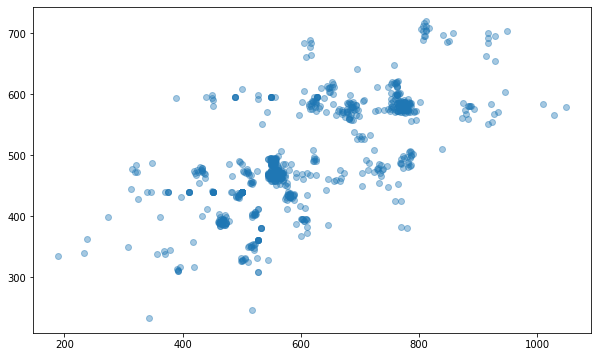

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(w, h, alpha=0.4)
plt.show()

In [0]:
del w, h

# Training on BUSI dataset

#### Metrics

In [0]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#### Loss functions

In [0]:
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def _tversky_index(y_true, y_pred, smooth=1.0, alpha=0.5):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    tp = K.sum(y_true * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)

    return (tp + smooth) / (tp + alpha * fn + (1 - alpha) * fp + smooth)


def tversky_loss(smooth_tversky=1.0, alpha=0.5):
    def compute_loss(y_true, y_pred):
        return 1 - _tversky_index(y_true, y_pred,
                                    smooth=smooth_tversky, alpha=alpha)
    return compute_loss


def focal_tversky_loss(gamma=0.75, smooth_tversky=1.0, alpha=0.5):
    def compute_loss(y_true, y_pred):
        pt_1 = _tversky_index(y_true, y_pred,
                                smooth=smooth_tversky, alpha=alpha)
        return K.pow((1 - pt_1), gamma)
    return compute_loss

In [0]:
criterion = tversky_loss(alpha=0.7)

#### Generator


In [0]:
class BaseGenerator(Iterator):
    def __init__(
        self,
        fnames,
        data_dir='.',
        n_classes=1,
        resized_shape=(256, 256),
        batch_size=8,
        shuffle=False,
        seed=None,
        **kwargs
    ):
        """Generator initialization, inherits Iterator class

        Arguments:
            fnames {list} -- List of filenames from dataset (not including extension part)

        Keyword Arguments:
            data_dir {str} -- The main dataset directory (default: {'.'})
            n_classes {int} -- Number of classes (default: {1})
            resized_shape {tuple} -- All images are reshaped to this size (default: {(256, 256)})
            batch_size {int} -- Batch size (default: {8})
            shuffle {bool} -- (default: {False})
        """
        self.fnames = fnames
        self.data_dir = data_dir
        self.seed = seed
        self.ids = np.array(range(len(fnames)))
        self.n_samples = len(self.ids)
        self.resized_shape = resized_shape
        
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.cursor = 0

        self.img_gen = ImageDataGenerator(**kwargs)
        self.msk_gen = ImageDataGenerator(**kwargs)

    def __len__(self):
        return math.ceil(self.n_samples / self.batch_size)
    
    def on_epoch_end(self):
        self.cursor = 0
        if self.shuffle:
            np.random.shuffle(self.ids)

    def __getitem__(self, idx):
        indices = self.ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        imgs, msks = self._read_data(indices)
        imgs, msks = self._preprocessing(imgs, msks)
        return imgs, msks

    def _preprocessing(self, imgs, msks=None):
        # imgs[..., 0] -= 103.939
        # imgs[..., 1] -= 116.779
        # imgs[..., 2] -= 123.68
        imgs /= 255
        # imgs -= 1.
        imgs = self.img_gen.random_transform(x=imgs, seed=self.seed)
        if msks is not None:
            msks /= 255
            msks = self.msk_gen.random_transform(x=msks, seed=self.seed)
            return imgs, msks
        return imgs

    def _read_data(self, ids):
        raise NotImplementedError

class BUSIGenerator(BaseGenerator):
    def __init__(self, fnames, input_channel=3, **kwargs):
        super(BUSIGenerator, self).__init__(fnames, **kwargs)
        self.input_channel = input_channel

    def _read_data(self, ids):
        imgs = np.empty((self.batch_size, self.resized_shape[0],
                        self.resized_shape[1], self.input_channel))
        msks = np.empty((self.batch_size, self.resized_shape[0], self.resized_shape[1], 1))

        for i, index in enumerate(ids):
            file_name = self.fnames[index]
            read_im_mode = 1
            if self.input_channel == 1:
                read_im_mode = 0
            img = cv2.imread(os.path.join(self.data_dir, 'images', f'{file_name}.png'), read_im_mode)
            msk = cv2.imread(os.path.join(self.data_dir, 'masks', f'{file_name}.png'), 0)

            if self.resized_shape:
                img = cv2.resize(img, self.resized_shape)
                msk = cv2.resize(msk, self.resized_shape)

            if self.input_channel == 1:
                img = np.expand_dims(img, axis=2)
            imgs[i] = img
            msks[i] = np.expand_dims(msk, axis=2)
        
        return imgs, msks

In [0]:
BATCH_SIZE = 8
input_shape = (256, 256, 1)

In [0]:
fnames = [os.path.splitext(f)[0] for f in os.listdir('./images')]

In [0]:
from sklearn.model_selection import train_test_split
im_train, im_val, ms_train, ms_val = train_test_split(fnames, fnames, test_size=0.15, random_state=10)
im_train, im_test, ms_train, ms_test = train_test_split(im_train, ms_train, test_size=0.3, random_state=10)

In [25]:
print(len(im_train))
print(len(im_val))
print(len(im_test))

560
142
241


In [0]:
train_gen = BUSIGenerator(im_train, batch_size=BATCH_SIZE, input_channel=input_shape[-1],
                          resized_shape=(input_shape[0], input_shape[1]), 
                          horizontal_flip=True, seed=10)
val_gen = BUSIGenerator(im_val, batch_size=BATCH_SIZE, input_channel=input_shape[-1],
                        resized_shape=(input_shape[0], input_shape[1]), 
                        horizontal_flip=True, seed=10)
# rotation_range=20, width_shift_range=10,

#### Callbacks

In [0]:
callbacks = [
    ModelCheckpoint('model_{}--{{epoch:02d}}-{{val_dice_coef:.2f}}.h5'.format('tversky'), monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=8),
    ReduceLROnPlateau(monitor='val_loss', patience=3)
]

#### Training

In [27]:
!nvidia-smi

Thu May 14 03:03:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
model = STAN(1, input_shape=input_shape, decode_mode='transpose')
# model.summary()

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=criterion, metrics=[dice_coef])

In [59]:
history = model.fit(x=train_gen, epochs=200, batch_size=BATCH_SIZE,
                    steps_per_epoch=len(train_gen), callbacks=callbacks,
                    validation_data=val_gen, validation_steps=1)

Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 0.8135 - dice_coef: 0.1277
Epoch 00001: val_dice_coef improved from -inf to 0.18419, saving model to model_tversky--01-0.18.h5
70/70 [==============================] - 18s 252ms/step - loss: 0.8135 - dice_coef: 0.1277 - val_loss: 0.7266 - val_dice_coef: 0.1842 - lr: 1.0000e-04
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 0.8056 - dice_coef: 0.1298
Epoch 00002: val_dice_coef improved from 0.18419 to 0.22525, saving model to model_tversky--02-0.23.h5
70/70 [==============================] - 17s 245ms/step - loss: 0.8056 - dice_coef: 0.1298 - val_loss: 0.7032 - val_dice_coef: 0.2253 - lr: 1.0000e-04
Epoch 3/200
70/70 [==============================] - ETA: 0s - loss: 0.7272 - dice_coef: 0.2090
Epoch 00003: val_dice_coef improved from 0.22525 to 0.23397, saving model to model_tversky--03-0.23.h5
70/70 [==============================] - 17s 249ms/step - loss: 0.7272 - dice_coef: 0.2090 - val_loss: 0

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef', 'lr'])


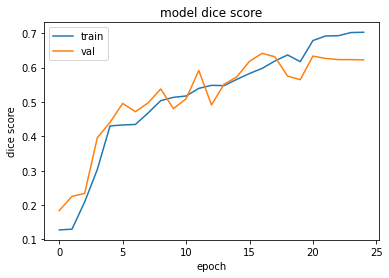

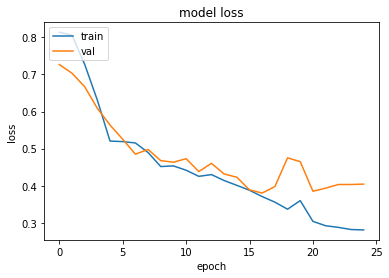

In [60]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice score')
plt.ylabel('dice score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [0]:
model = STAN(1, input_shape=input_shape, decode_mode='transpose')
model.load_weights('model_tversky--17-0.64.h5')
model.compile(loss=criterion, metrics=[dice_coef])

In [69]:
test_gen = BUSIGenerator(im_test, batch_size=BATCH_SIZE, input_channel=input_shape[-1],
                        resized_shape=(input_shape[0], input_shape[1]), seed=10)
model.evaluate(test_gen)

31/31 [==============================] - 4s 128ms/step - loss: 0.3460 - dice_coef: 0.6255


[0.34600117802619934, 0.6255363821983337]

### Prediction visualization

In [0]:
im, mk =  test_gen[6]
pred = model.predict(im)

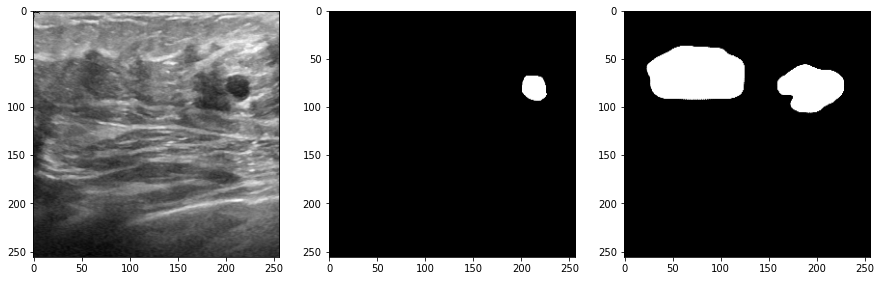

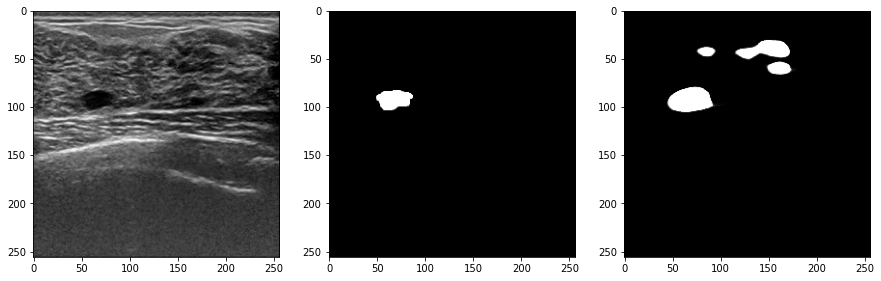

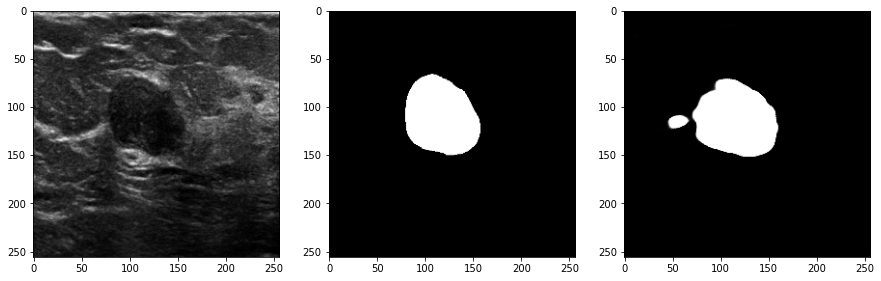

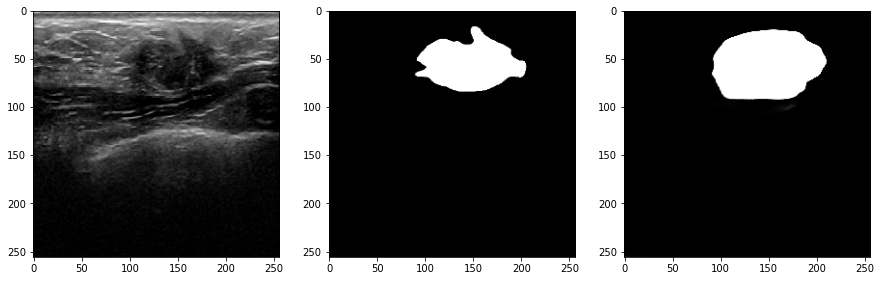

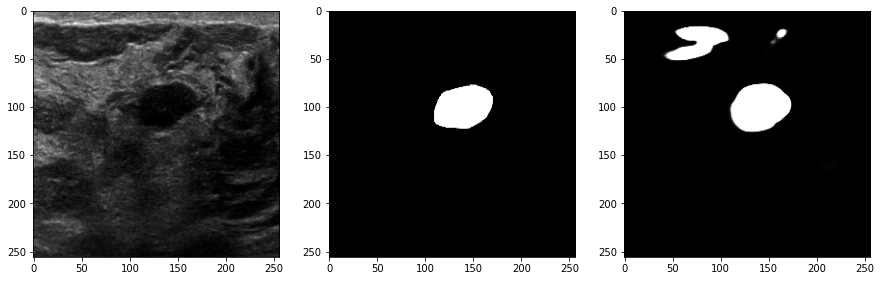

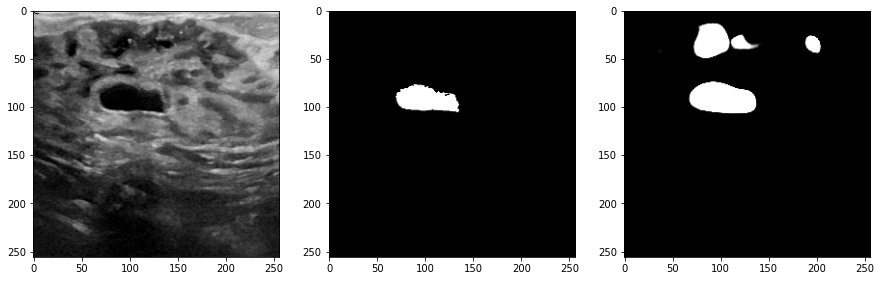

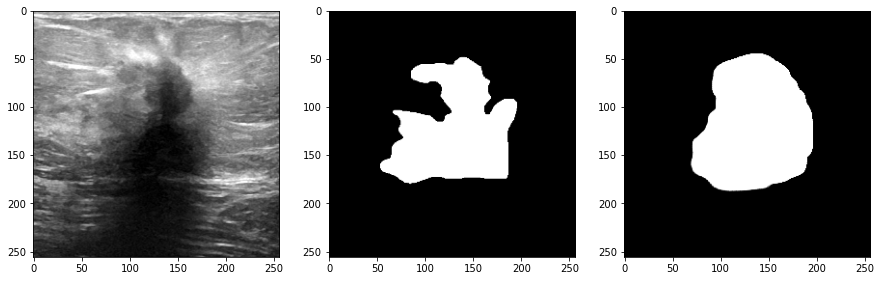

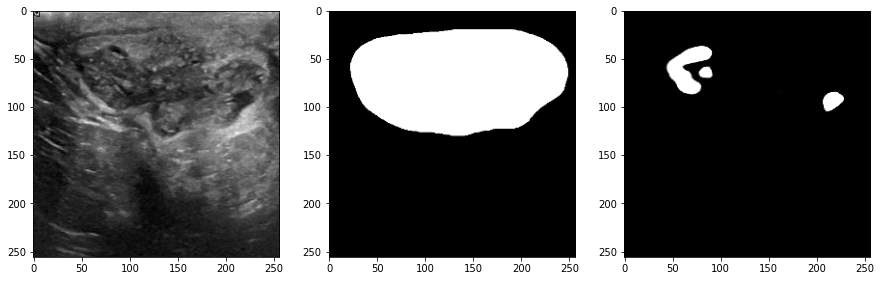

In [64]:
for i in range(8):
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].imshow(im[i][..., 0], cmap='gray')
    ax[1].imshow(mk[i][..., 0], cmap='gray')
    ax[2].imshow(pred[i][...,0], cmap='gray')
    plt.show()